# Sentence Pairs
To do - 
Predict Contradiction / Non - Contradiction of pair of statements

- tfidf
- word2vec


In [40]:
# Importing the libraries
import numpy as np
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Loading the dataset
df = pd.read_csv('./data/quora_pairs/dataset.txt', header = None, sep = "\t").drop(3, axis = 1)
# df = pd.read_fwf('./data/quora_pairs/dataset.txt', sep = "\t")


# EDA

In [42]:
# Renaming the columns
df.columns = ['id', 'statement_1', 'statement_2', 'label']

In [43]:
# Checking the value counts
df.label.value_counts()

NEUTRAL          2536
ENTAILMENT       1299
CONTRADICTION     665
Name: label, dtype: int64

In [44]:
# Changing the labels 'neutral' and 'entailment' to 'non-contradiction'
df.loc[(df.label == 'NEUTRAL') | (df.label == 'ENTAILMENT'), 'label'] = 'NON-CONTRADICTION'

# Changing labels to 0 / 1
df.loc[(df.label == 'NON-CONTRADICTION'), 'label'] = 0
df.loc[(df.label == 'CONTRADICTION'), 'label'] = 1

In [45]:
# Overview of data
df.head()

,id,statement_1,statement_2,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,0
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,0
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,0
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,0
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           4500 non-null   int64 
 1   statement_1  4500 non-null   object
 2   statement_2  4500 non-null   object
 3   label        4500 non-null   object
dtypes: int64(1), object(3)
memory usage: 140.8+ KB


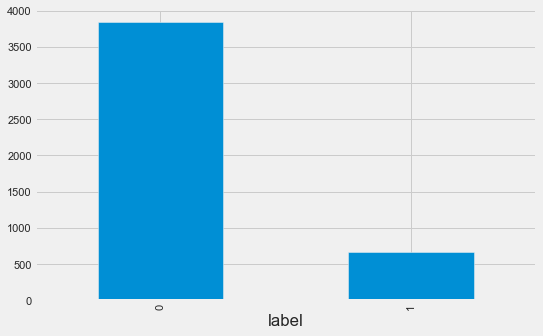

In [47]:
df.groupby('label')['id'].count().plot.bar();

### Number of unique statements

In [48]:
print('Total Number of Statements: {}'.format(len(df)))
print('Contradiction pairs: {}%'.format(round(df['label'].mean() * 100, 2)))

# Finding the total, unique and repeated number of statements
total_statements = pd.Series(df['statement_1'].tolist() + df['statement_2'].tolist())
unique_statements = len(np.unique(total_statements))
repeated_statements = np.sum(total_statements.value_counts() > 1)

print('Total number of unique statements: {}'.format(unique_statements))
print('Number of statements appearing more than once: {}'.format(repeated_statements))
print('Max number of times a single statement is repeated: {}'.format(max(total_statements.value_counts())))

Total Number of Statements: 4500
Contradiction pairs: 14.78%
Total number of unique statements: 4802
Number of statements appearing more than once: 2445
Max number of times a single statement is repeated: 31


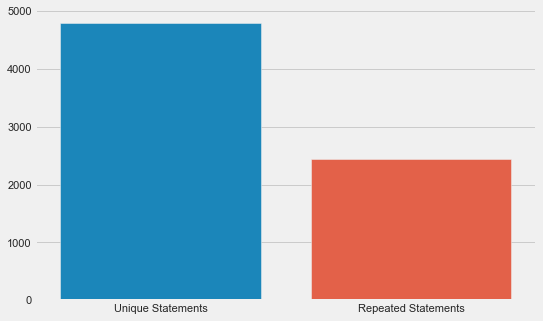

In [49]:
sns.barplot(x = ["Unique Statements", "Repeated Statements"], y = [unique_statements, repeated_statements]);

In [50]:
df.label.value_counts()

0    3835
1     665
Name: label, dtype: int64

### Number of duplicate entries - v1

In [51]:
# Checking for repeated pair of questions
pair_duplicates = df[['statement_1', 'statement_2', 'label']].groupby(['statement_1', 'statement_2']).count().reset_index()
print('Number of duplicate pair of statements: {}'.format(df.shape[0] - pair_duplicates.shape[0]))

df_v1 = pair_duplicates.copy()

Number of duplicate pair of statements: 30


In [52]:
df.label.value_counts()

0    3835
1     665
Name: label, dtype: int64

### Number of occurances of each statement

Max number of times a single statement is repeated: 31


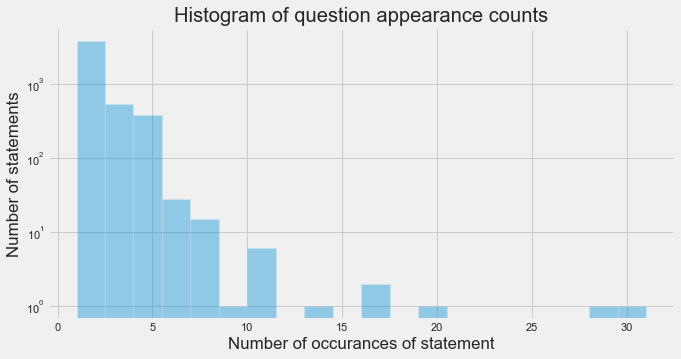

In [53]:
plt.figure(figsize=(10, 5))
sns.distplot(total_statements.value_counts(), bins = 20, kde = False)
plt.yscale('log', nonposy='clip')
plt.xlabel('Number of occurances of statement')
plt.ylabel('Number of statements')
plt.title('Histogram of question appearance counts')
print('Max number of times a single statement is repeated: {}'.format(max(total_statements.value_counts())))

In [54]:
total_statements = pd.DataFrame({'statements': total_statements})

In [55]:
total_statements['num_of_words'] = total_statements['statements'].apply(lambda x: len(str(x).split()))
total_statements.head()

,statements,num_of_words
0,A group of kids is playing in a yard and an ol...,18
1,A group of children is playing in the house an...,18
2,The young boys are playing outdoors and the ma...,12
3,The kids are playing outdoors near a man with ...,11
4,The young boys are playing outdoors and the ma...,12


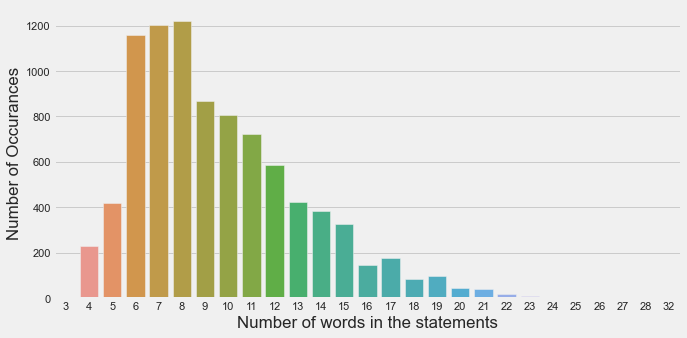

In [56]:
count_words = total_statements.num_of_words.value_counts()
plt.figure(figsize = (10, 5))
sns.barplot(count_words.index, count_words.values)
plt.ylabel('Number of Occurances')
plt.xlabel('Number of words in the statements')
plt.show()

We can see that the max number of statements have around 6 - 8 words

In [57]:
# # !pip install wordcloud
# from wordcloud import WordCloud
# cloud = WordCloud(width=1440, height=1080).generate(" ".join(total_statements.astype(str)))
# plt.figure(figsize=(10, 7.5))
# plt.imshow(cloud)
# plt.axis('off')

# Feature Extraction

In [58]:
df.head()

,id,statement_1,statement_2,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,0
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,0
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,0
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,0
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,0


In [59]:
df.drop('id', axis = 1, inplace = True)

In [60]:
# Loading the libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import validation_curve

In [61]:
tfidf = TfidfVectorizer(analyzer = 'word',
                       stop_words = 'english', 
                       lowercase = True,
                       max_features = 300,
                       norm = 'l1')

In [62]:
BagOfWords = pd.concat([df_v1.statement_1, df_v1.statement_2], axis = 0)

In [63]:
tfidf.fit(BagOfWords)

TfidfVectorizer(max_features=300, norm='l1', stop_words='english')

In [64]:
train_s1_tf = tfidf.transform(df.statement_1)
train_s2_tf = tfidf.transform(df.statement_2)

In [65]:
X = abs(train_s1_tf - train_s2_tf)
y = df.label
y = y.astype('int')

In [66]:
y.value_counts()

0    3835
1     665
Name: label, dtype: int64

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

# Model Building

### Baseline Model - Logistic Regression

In [68]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [69]:
pred_lr = lr.predict(X_test)
pred_lr_prob = lr.predict_proba(X_test)
accuracy_lr = accuracy_score(y_test, pred_lr)
loss_lr = log_loss(y_test, pred_lr_prob)
print("The accuracy achieved by using LR: {}".format(round(accuracy_lr, 2)))
print("The loss achieved by using LR: {}".format(round(loss_lr, 2)))

The accuracy achieved by using LR: 0.82
The loss achieved by using LR: 0.38


### Random Forest

In [70]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=10, n_estimators=200, n_jobs=-1)

In [71]:
pred_rf = rf.predict(X_test)
pred_rf_prob = rf.predict_proba(X_test)
accuracy_rf = accuracy_score(y_test, pred_rf)
loss_rf = log_loss(y_test, pred_rf_prob)
print("The accuracy achieved by using RF: {}".format(round(accuracy_rf, 2)))
print("The log loss achieved by using RF: {}".format(round(loss_rf, 2)))

The accuracy achieved by using RF: 0.83
The log loss achieved by using RF: 0.35


### Randomized Search

In [91]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 50),
              "min_samples_split": sp_randint(2, 10),
              "min_samples_leaf": sp_randint(1, 10),
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring='f1')

In [92]:
random_search.fit(X, y);

In [93]:
random_search.best_score_

0.017518248175182483

In [94]:
random_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 6}

### XGBoost

In [76]:
# !pip install xgboost
import xgboost as xgb

# Set params
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label = y_train)
d_test = xgb.DMatrix(X_test, label = y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params,d_train, 800, watchlist, early_stopping_rounds = 50, verbose_eval = 100)

[0]	train-logloss:0.68199	test-logloss:0.68315
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.35605	test-logloss:0.40810
[200]	train-logloss:0.31750	test-logloss:0.38045
[300]	train-logloss:0.30074	test-logloss:0.36723
[400]	train-logloss:0.29015	test-logloss:0.35917
[500]	train-logloss:0.28295	test-logloss:0.35367
[600]	train-logloss:0.27741	test-logloss:0.34952
[700]	train-logloss:0.27287	test-logloss:0.34627
[799]	train-logloss:0.26880	test-logloss:0.34423
